In [1]:
import os
import cv2
import h5py
import numpy
import keras
from PIL import Image
import tensorflow as tf
import prepare_data as pd
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, Activation, Conv2DTranspose
from tensorflow.keras import regularizers  

Using TensorFlow backend.


In [2]:
#TRAINING DATA PREPARATION
DATA_PATH = "yang91/"
Random_Crop = 10
Patch_size = 24
label_size = 96
scale = 4


def prepare_training_data():
    names = os.listdir(DATA_PATH)
    names = sorted(names)
    nums = names.__len__()

    data = numpy.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=numpy.double)
    label = numpy.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=numpy.double)

    for i in range(nums):
        name = DATA_PATH + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        # produce Random_Crop random coordinate to crop training img
        if(min(shape[0], shape[1]) - label_size < 0):
            continue
        Points_x = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)
        Points_y = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)

        for j in range(Random_Crop):
            hr_patch = hr_img[Points_x[j]: Points_x[j] + label_size, Points_y[j]: Points_y[j] + label_size]
            lr_patch = cv2.resize(hr_patch, (label_size // scale, label_size // scale), cv2.INTER_CUBIC)

            lr_patch = lr_patch.astype(float) // 255.
            hr_patch = hr_patch.astype(float) // 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch
            # cv2.imshow("lr", lr_patch)
            # cv2.imshow("hr", hr_patch)
            # cv2.waitKey(0)
    return data, label


def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(numpy.float32)
    y = labels.astype(numpy.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()


def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
        label = numpy.array(hf.get('label'))
        train_data = numpy.transpose(data, (0, 2, 3, 1))
        train_label = numpy.transpose(label, (0, 2, 3, 1))
        return train_data, train_label


if __name__ == "__main__":
    data, label = prepare_training_data()
    write_hdf5(data, label, "WAZIR_TRAINING_FILE.h5")
    # _, _a = read_training_data("train.h5")
    # _, _a = read_training_data("test.h5")

In [3]:
#TRAINING DATA PREPARATION
DATA_PATH = "General-100/"
Random_Crop = 10
Patch_size = 24
label_size = 96
scale = 4


def prepare_training_data():
    names = os.listdir(DATA_PATH)
    names = sorted(names)
    nums = names.__len__()

    data = numpy.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=numpy.double)
    label = numpy.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=numpy.double)

    for i in range(nums):
        name = DATA_PATH + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        # produce Random_Crop random coordinate to crop training img
        if(min(shape[0], shape[1]) - label_size < 0):
            continue
        Points_x = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)
        Points_y = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)

        for j in range(Random_Crop):
            hr_patch = hr_img[Points_x[j]: Points_x[j] + label_size, Points_y[j]: Points_y[j] + label_size]
            lr_patch = cv2.resize(hr_patch, (label_size // scale, label_size // scale), cv2.INTER_CUBIC)

            lr_patch = lr_patch.astype(float) // 255.
            hr_patch = hr_patch.astype(float) // 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch
            # cv2.imshow("lr", lr_patch)
            # cv2.imshow("hr", hr_patch)
            # cv2.waitKey(0)
    return data, label


def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(numpy.float32)
    y = labels.astype(numpy.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()


def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
        label = numpy.array(hf.get('label'))
        train_data = numpy.transpose(data, (0, 2, 3, 1))
        train_label = numpy.transpose(label, (0, 2, 3, 1))
        return train_data, train_label


if __name__ == "__main__":
    data, label = prepare_training_data()
    write_hdf5(data, label, "WAZIR_TEST_FILE.h5")
    # _, _a = read_training_data("train.h5")
    # _, _a = read_training_data("test.h5")

In [4]:
def model_WAZIR():
    _input = Input(shape=(None, None, 1), name='INPUT_LR_IMAGE')
    
    #FIRST LAYER IS USED TO EXTRACT THE FEATURES
    C1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=regularizers.l1(10e-10),name='FIRST_LAYER')(_input)
    A1 = Activation('relu', name='act1')(C1)
    C2 = Conv2D(64, (3,3),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV2')(A1)
    A2 = Activation('relu', name='act2')(C2)
    C3 = Conv2D(64, (3,3),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV3')(A2)
    A3 = Activation('relu', name='act3')(C3)
    Sum1  = tf.keras.layers.add([C2,A3])
    
    C4 = Conv2D(64, (1,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV4')(Sum1)
    T1 = Conv2DTranspose(4, (14,14), strides = (scale,scale), padding="same",activation=None,kernel_regularizer=regularizers.l1(10e-10),name='UPSCALING')(C4)
    C5 = Conv2D(64, (1,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV5')(T1)
    
    
    #FIRST BLOCK
    C6 = Conv2D(64, (3,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV6')(C5)
    C7 = Conv2D(64, (1,3),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV7')(C6)
    A4 = Activation('relu', name='act4')(C7)
    C8 = Conv2D(64, (3,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV8')(A4)
    C9 = Conv2D(64, (1,3),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV9')(C8)
    A5 = Activation('relu', name='act5')(C9)
    Sum2  = tf.keras.layers.add([C5,A5])
    
    
    #SECOND BLOCK
    C10 = Conv2D(64, (3,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV10')(Sum2)
    C11 = Conv2D(64, (1,3),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV11')(C10)
    A6 = Activation('relu', name='act6')(C11)
    C12 = Conv2D(64, (3,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV12')(A6)
    C13 = Conv2D(64, (1,3),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV13')(C12)
    A6 = Activation('relu', name='act7')(C13)
    Sum3  = tf.keras.layers.add([Sum2,A6])
    
    #TOWER 1
    C14 = Conv2D(3, (3,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV14')(Sum3)
    C15 = Conv2D(3, (1,3),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV15')(C14)
    A7 = Activation('relu', name='act8')(C15)
    C16 = Conv2D(3, (5,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV16')(A7)
    C17 = Conv2D(3, (1,5),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV17')(C16)
    A8 = Activation('relu', name='act9')(C17)
    
    
    #TOWER 2
    C18 = Conv2D(3, (3,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV18')(Sum3)
    C19 = Conv2D(3, (1,3),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV19')(C18)
    A9 = Activation('relu', name='act10')(C19)
    C20 = Conv2D(3, (5,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV20')(A9)
    C21 = Conv2D(3, (1,5),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV21')(C20)
    A10 = Activation('relu', name='act11')(C21)
    
    
    #TOWER 3
    C22 = Conv2D(3, (3,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV22')(Sum3)
    C23 = Conv2D(3, (1,3),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV23')(C22)
    A11 = Activation('relu', name='act12')(C23)
    C24 = Conv2D(3, (5,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV24')(A11)
    C25 = Conv2D(3, (1,5),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV25')(C24)
    A12 = Activation('relu', name='act13')(C25)
    
    
    #TOWER 4
    C26 = Conv2D(3, (7,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV26')(Sum3)
    C27 = Conv2D(3, (1,7),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV27')(C26)
    A13 = Activation('relu', name='act14')(C27)
    C28 = Conv2D(3, (9,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV28')(A13)
    C29 = Conv2D(3, (1,9),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV29')(C28)
    A14 = Activation('relu', name='act15')(C29)
    
    #TOWER 5
    C30 = Conv2D(3, (7,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV30')(Sum3)
    C31 = Conv2D(3, (1,7),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV31')(C30)
    A15 = Activation('relu', name='act16')(C31)
    C32 = Conv2D(3, (9,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV32')(A15)
    C33 = Conv2D(3, (1,9),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV33')(C32)
    A16 = Activation('relu', name='act17')(C33)
    Sum4  = tf.keras.layers.add([A8,A10,A12,A14,A16])
    
    C34 = Conv2D(1, (1,1),padding="same",kernel_regularizer=regularizers.l1(10e-10),name='CONV34')(Sum4)
    
    model = Model(inputs=_input , outputs = C34)
    return model

In [5]:
WAZIR = model_WAZIR()

In [6]:
WAZIR.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT_LR_IMAGE (InputLayer)     [(None, None, None,  0                                            
__________________________________________________________________________________________________
FIRST_LAYER (Conv2D)            (None, None, None, 6 640         INPUT_LR_IMAGE[0][0]             
__________________________________________________________________________________________________
act1 (Activation)               (None, None, None, 6 0           FIRST_LAYER[0][0]                
__________________________________________________________________________________________________
CONV2 (Conv2D)                  (None, None, None, 6 36928       act1[0][0]                       
______________________________________________________________________________________________

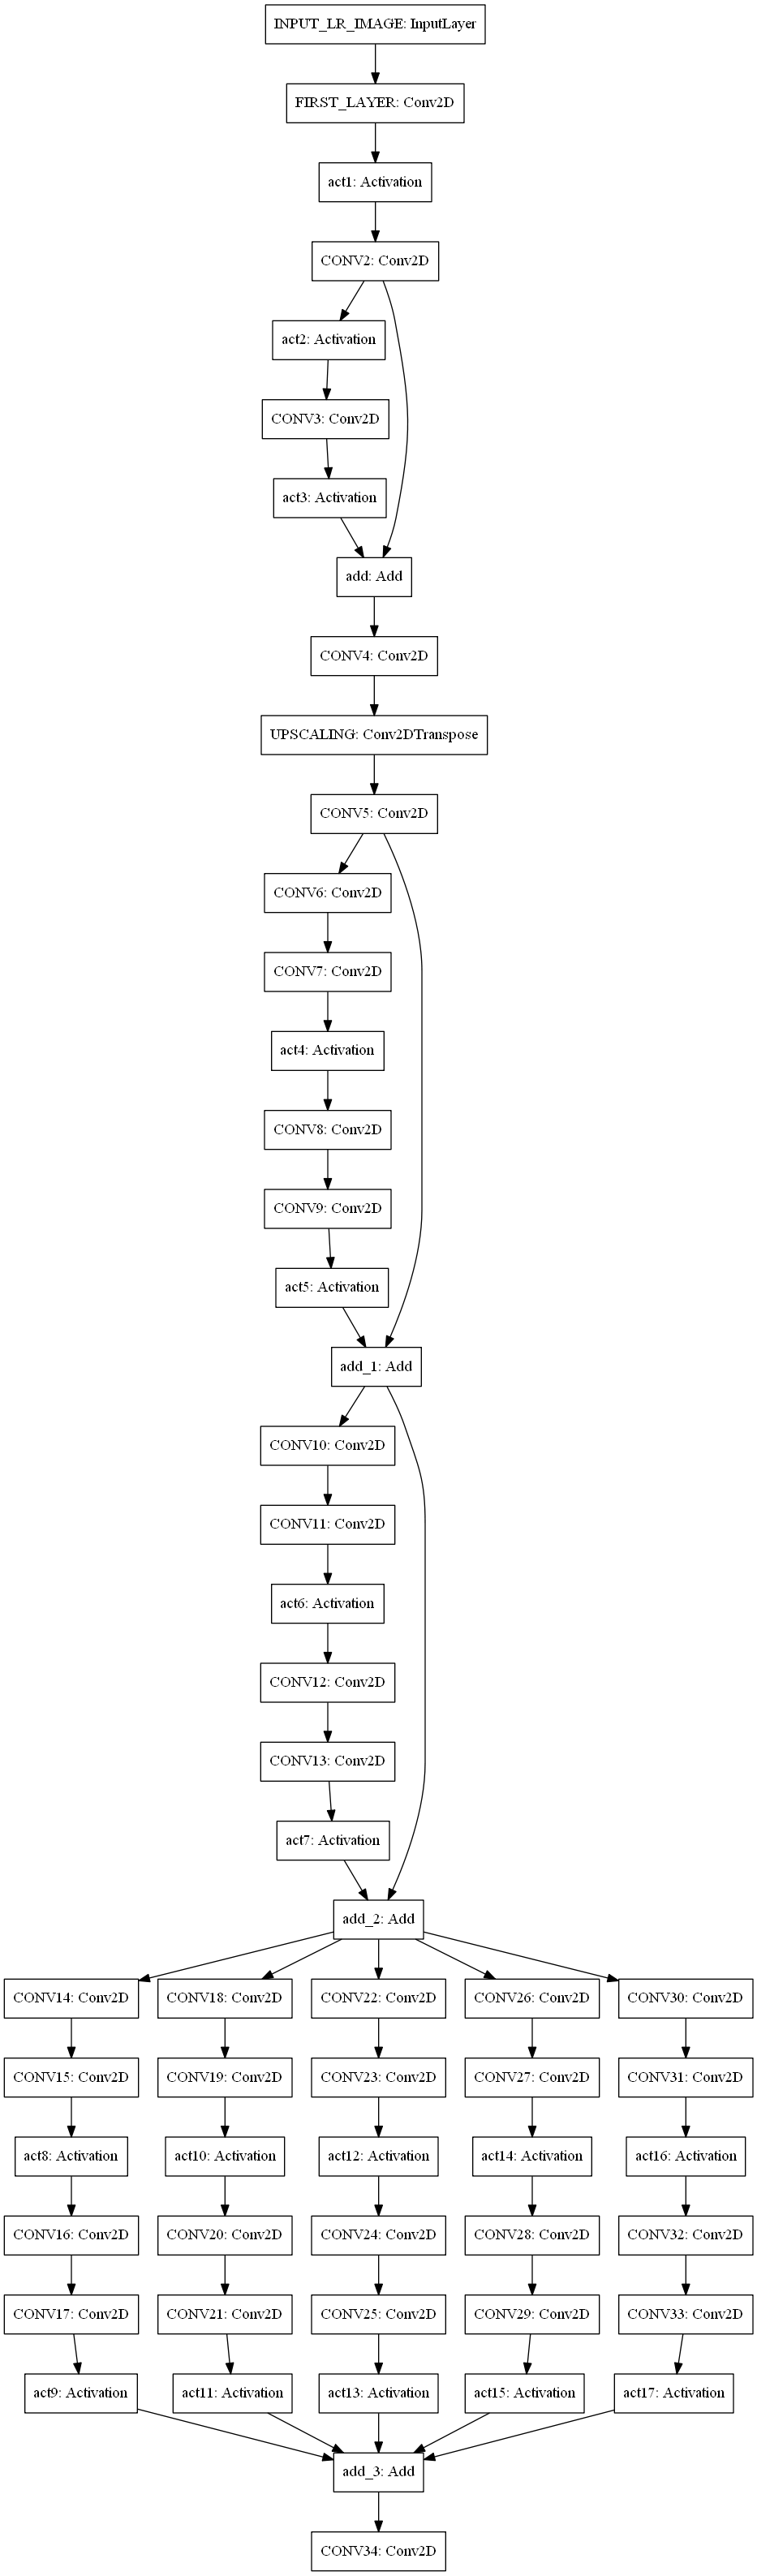

In [7]:
tf.keras.utils.plot_model(WAZIR, 'WAZIR_PROPOSED_MODEL.png')

In [34]:
def WAZIR_train():
    WAZIR = model_WAZIR()
    WAZIR.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0003), loss='mse',metrics=["acc"])
    data, label = pd.read_training_data("WAZIR_TRAINING_FILE.h5")
    val_data, val_label = pd.read_training_data("WAZIR_TEST_FILE.h5")
    checkpoint = ModelCheckpoint('best_model_improved.h5',monitor='val_loss',verbose=0,save_best_only= True,mode='min')
    es = EarlyStopping(monitor='val_loss',mode = 'min',verbose=1, patience=5)
    history = WAZIR.fit(data, label,batch_size=128,shuffle=False,validation_data=(val_data, val_label) ,epochs=30,
                        callbacks=[checkpoint],verbose=1)
    WAZIR.save_weights("WAZIR_MODEL_SCALE_2TESTING_FILE.h5")

    
def WAZIR_predict():
    WAZIR = model_WAZIR()
    WAZIR.load_weights("best_model_improved.h5")
    IMG_NAME = "baby_GT.png"
    INPUT_NAME = "INPUT_LOW_RESOLUTION_IMAGE.png"
    OUTPUT_NAME = "MODEL_OUTPUT_IMAGE.png"
    
    
    
    import cv2
    img = cv2.imread(IMG_NAME)
    shape = img.shape
    img = cv2.resize(img, (shape[1] // scale, shape[0] // scale), cv2.INTER_CUBIC)
    cv2.imwrite(INPUT_NAME, img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1))
    Y[0, :, :, 0] = img[:, :, 0]
    img = cv2.resize(img, (shape[1], shape[0]), cv2.INTER_CUBIC)

    pre = WAZIR.predict(Y, batch_size=1)
    pre[pre[:] > 255] = 255
    pre = pre.astype(numpy.uint8)
    img[:, :, 0] = pre[0, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(OUTPUT_NAME, img)

    # psnr calculation:
    im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)
    
    im2 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)

    
    print ("WAZIR_MODEL:")
    print (cv2.PSNR(im1, im2))


if __name__ == "__main__":
    WAZIR_train()
    WAZIR_predict()

Train on 7500 samples, validate on 1000 samples
Epoch 1/30
7500/7500 [==============================] - 35s 5ms/sample - loss: 0.0029 - acc: 0.9967 - val_loss: 0.0034 - val_acc: 0.9959
Epoch 2/30
7500/7500 [==============================] - 33s 4ms/sample - loss: 0.0017 - acc: 0.9979 - val_loss: 0.0029 - val_acc: 0.9963
Epoch 3/30
7500/7500 [==============================] - 33s 4ms/sample - loss: 0.0016 - acc: 0.9980 - val_loss: 0.0026 - val_acc: 0.9968
Epoch 4/30
7500/7500 [==============================] - 35s 5ms/sample - loss: 0.0015 - acc: 0.9981 - val_loss: 0.0023 - val_acc: 0.9971
Epoch 5/30
7500/7500 [==============================] - 35s 5ms/sample - loss: 0.0014 - acc: 0.9982 - val_loss: 0.0022 - val_acc: 0.9972
Epoch 6/30
7500/7500 [==============================] - 34s 5ms/sample - loss: 0.0014 - acc: 0.9983 - val_loss: 0.0021 - val_acc: 0.9974
Epoch 7/30
7500/7500 [==============================] - 35s 5ms/sample - loss: 0.0013 - acc: 0.9983 - val_loss: 0.0024 - val_acc: 

In [9]:
#31.517153454502544 (batch-128,epoch=10), 31.841406636743375 (batch-128,epoch=10), 31.939465862945212 (batch-128,epoch=20)

In [ ]:
Bicubic = cv2.imread('INPUT_LOW_RESOLUTION_IMAGE.png',cv2.IMREAD_COLOR)
bicubic_img = cv2.resize(Bicubic,None, fx = scale, fy = scale, interpolation = cv2.INTER_CUBIC)
cv2.imwrite('bicubic.png',bicubic_img)

In [ ]:
GT_IMAGE = Image.open("baby_GT.png")############################################################
LR_IMAGE = Image.open("INPUT_LOW_RESOLUTION_IMAGE.png")
Bicubic_Upscale = Image.open("bicubic.png")
MODEL_IMAGE = Image.open("MODEL_OUTPUT_IMAGE.png")

In [ ]:
fig = plt.figure(figsize =(14,14),dpi=100)
ax = plt.subplot("141")
ax.imshow(GT_IMAGE)
ax.set_title('ORIGINAL GT IMAGE')
plt.axis('off')

ax = plt.subplot("142")
ax.imshow(LR_IMAGE)
ax.set_title('LR IMAGE IMAGE')
plt.axis('off')

ax = plt.subplot("143")
ax.imshow(Bicubic_Upscale)
ax.set_title('BICUBIC_UPSCALE_IMAGE')
plt.axis('off')

ax = plt.subplot("144")
ax.imshow(MODEL_IMAGE)
ax.set_title('WAZIR_MODEL_OUTPUT_IMAGE')
plt.axis('off')

In [ ]:
#img1 = cv2.imread('baby_GT.png', cv2.IMREAD_UNCHANGED)
#cv2.imshow('GT_Image',img1)

#img2 = cv2.imread('INPUT_LOW_RESOLUTION_IMAGE.png', cv2.IMREAD_UNCHANGED)
#cv2.imshow('4X_LRIMAGE',img2)

#img3 = cv2.imread('bicubic.png', cv2.IMREAD_UNCHANGED)
#cv2.imshow('BICUBIC_UPSCALE_IMAGE',img3)

#img4 = cv2.imread('MODEL_OUTPUT_IMAGE.png', cv2.IMREAD_UNCHANGED)
#cv2.imshow('MODEL_IMAGE',img4)

#cv2.waitKey(0) #image will not show until this is called
#cv2.destroyAllWindows() #make sure window closes cleanly